# Regularization Bias in Causal Models
Julian Hsu
15-july-2023


We look for regularization bias in causal model by replicating **Figure 1** from the Chernozhukov et al (2016) Double-De-biased ML [paper](https://arxiv.org/pdf/1608.00060.pdf). Specifically, we estimate two partial linear models using the residualized outcome, $\tilde{Y}_i = Y_i - g_0(X_i)$, and the residualized treatment, $\tilde{W}_i = W_i - m_0(X_i)$:

$$ \tilde{Y}_i = \tau W_i + \epsilon_i \hspace{5cm} (EQ 1) $$
$$ \tilde{Y}_i = \tau \tilde{W}_i + \eta_i \hspace{5cm} (EQ 2) $$

we first estimate $Y$ using a given ML model $g_0$, and then estimate an OLS regression of $Y_i - \hat{Y_i}(X_i) = \beta_0 + \tau W_i + \epsilon_i$. 

We will also compare estimates from OLS to Ridge regression estimates. Ex-ante, OLS estimates are causal because there is no regularization bias, while Ridge estimates should be recover the same estimate.



In [173]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score


Write a DGP function with a treatment indicator and confounding features.

The treatment effect will be a standard deviation of the potential control outcome.

In [174]:
def dgp(N=1000,K=3,ate_sd = 0.1
       , allow_log=True):
    '''
    N  number of rows
    K  number of confounding variables
    ate_sd  the impact in standard deviations of the outcome
    allow_log  all logs of the confounders to enter into outcome and treatment
    '''
    
    df_out = pd.DataFrame()
    ## Create covariates
    for k in range(K):
        df_out['x{0:1.0f}'.format(k)] = np.random.normal(0,0.50,N)
    ## Alternate between positive and negative coefficient estimates
    ## for the outcome and treatment
    y_array = np.random.uniform(1,2,K) * [1-2*(i%2) for i in range(K)]
    t_array = np.random.uniform(1,2,K) * [1-2*(i%2) for i in range(K)]
    
    if allow_log==True:
        y_array_log = np.random.uniform(0.5,1,K) * [-1+2*(i%2) for i in range(K)]
        t_array_log = np.random.uniform(0.5,1,K) * [-1+2*(i%2) for i in range(K)]
    
    ## Create treatment indicator
    w_latent = np.dot(df_out[[e for e in df_out.columns if 'x' in e]], t_array)
    if allow_log==True:
        w_latent += np.dot(np.log(1+np.abs(df_out[[e for e in df_out.columns if 'x' in e]])), t_array_log)
        
    df_out['w'] = ( np.exp(w_latent) / (1+ np.exp(w_latent)) > np.random.uniform(0,1,N) ).astype(float)
    
    ## Create outcome 
    df_out['y'] = np.dot(df_out[[e for e in df_out.columns if 'x' in e]], y_array)
    if allow_log==True:
        df_out['y'] += np.dot(np.log(1+np.abs(df_out[[e for e in df_out.columns if 'x' in e]])), y_array_log)
        
    ate_to_use = ate_sd * df_out['y'].std()
    
    df_out['y'] += df_out['w']*ate_to_use
    df_out['y'] += np.random.normal(0,1, N)
    
    df_out['gt'] = ate_to_use
    
    return df_out

In [252]:
from sklearn.model_selection import train_test_split

## Estimate the treatment effect without sample-splitting
def ml_estimate(data=None,X_list=None
                , model_y=Ridge(alpha=1, fit_intercept=True)
                , model_t=LogisticRegression(penalty='l2', C=1, fit_intercept=True)
                , outcome_residualization=False
                , treatment_residualization=False):
    condition=((outcome_residualization==True ) | (treatment_residualization==True))
    assert condition ==True, 'Outcome or Treatment residualization must be True'
            
    
    if treatment_residualization==False:
        W = np.array(data['w']).reshape(-1, 1)
    else:
        ml_t_model = model_t.fit(X=data[X_list], y = data['w'] )        
        W = np.array(data['w'] - ml_t_model.predict_proba(data[X_list])[:,1]).reshape(-1,1)
        
    if outcome_residualization==False:
        YM = data['y'].values
    else:        
        ml_model = model_y.fit(X=data[X_list], y = data['y'] )    
        YM = data['y'] - ml_model.predict(data[X_list])


    ols_model_r = LinearRegression(fit_intercept=True).fit(X=W, y = YM)
        

    return ols_model_r.coef_[-1]

## EStimate with sample splitting
def ml_estimate_x(data=None, X_list=None,
                model=Ridge(alpha=1, fit_intercept=True)):
    ## Split estimate into random halves
    X1, X2, y1, y2 = train_test_split(data[X_list+['w']], data['y'], test_size=0.50, random_state=42)

    ml_model1 = model.fit(X=X1[X_list], y = y1 )
    ml_model2 = model.fit(X=X2[X_list], y = y2 )

    ols_model_r1 = LinearRegression(fit_intercept=True).fit(X=np.array(X2['w']).reshape(-1, 1), 
                                             y = y2 - ml_model1.predict(X2[X_list]))
    ols_model_r2 = LinearRegression(fit_intercept=True).fit(X=np.array(X1['w']).reshape(-1, 1), 
                                             y = y1 - ml_model2.predict(X1[X_list]))
    return (ols_model_r1.coef_[-1] + ols_model_r2.coef_[-1] ) / 2
    

In [253]:
## OLS and Ridge Linear Regression Estimates of a Treatment Effect
def ols_estimate(data=None,X_list=None):
    ols_model = LinearRegression(fit_intercept=True).fit(X=data[X_list+['w']], y = data['y'] )
    return ols_model.coef_[-1], r2_score(data['y'], ols_model.predict(data[X_list+['w']]) )

def ridge_estimate(data=None,X_list=None,a=1):
    ridge_model = Ridge(alpha=a, fit_intercept=True).fit(X=data[X_list+['w']], y = data['y'] )
    return ridge_model.coef_[-1], r2_score(data['y'], ridge_model.predict(data[X_list+['w']]))


## Simulations Demonstrating Regularization Bias

In [254]:
df_results = pd.DataFrame()
Stimes = 20
sd_list = [ 0.5]
for sd_ in sd_list:
    for s in range(Stimes):
        df = dgp(N=1000, K=4, ate_sd = sd_, allow_log=False)
        ml1 = ml_estimate(data=df, X_list=['x0','x1','x2','x3']
                    ,treatment_residualization=False
                    ,outcome_residualization=True )
        ml2 = ml_estimate(data=df, X_list=['x0','x1','x2','x3']
                    ,treatment_residualization=True
                    ,outcome_residualization=False )
        ml3 = ml_estimate(data=df, X_list=['x0','x1','x2','x3']
                    ,treatment_residualization=True
                    ,outcome_residualization=True )
        
        gt = df['gt'].mean()
        df_results = pd.concat([df_results, pd.DataFrame(index=[s], data={
                                                              'ml1':ml1  
                                                              ,'ml2':ml2
                                                                ,'ml3':ml3            
                                                              , 'gt':gt
                                                              , 'gt_sd':sd_})  ])
    

In [255]:
for r in ['ml1','ml2','ml3']:
    df_results[r+'_bias'] = df_results[r] - df_results['gt']
    df_results[r+'_bias_MAPE'] = df_results[r+'_bias'] / df_results['gt']


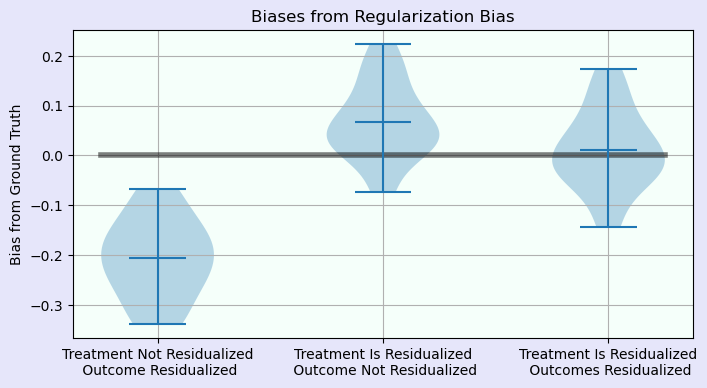

In [265]:
## Plot in violin plots
## add labels for violin plot following: https://stackoverflow.com/questions/33864578/matplotlib-making-labels-for-violin-plots
import matplotlib.patches as mpatches

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharey=True)
ax.plot([0.75,3.25], [0,0], color='black', linewidth=4, alpha=0.5)

ax.violinplot(df_results[['ml1_bias','ml2_bias', 'ml3_bias']]
                  ,showextrema=True
                     , showmeans=True)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Treatment Not Residualized\n Outcome Residualized'
                    ,'Treatment Is Residualized\n Outcome Not Residualized'
                   ,'Treatment Is Residualized\n Outcomes Residualized'])
ax.set_ylabel('Bias from Ground Truth')
ax.set_title('Biases from Regularization Bias')
ax.grid()
ax.set_facecolor('mintcream')
fig.set_facecolor('lavender')
plt.show()


**Sound byte** When you use ML models, it is *double or nothing.* Here I show that when only predict the outcome or treatment variable to do causal modeling, you will have bias in your estimate. Only when you residualize both the outcome *and* treatment will you get unbiased treatment effect estimates. This is because when you only residualize one, you are allowing regularization 

This post is inspired by Figure 1 from the DML paper (https://arxiv.org/pdf/1608.00060.pdf), where I also look at biases when you only residualize the treatment variable. 

Check out the simulation notebook for more details! (link)

## Simulations comparing Elastic Net to OLS
Generate a lot of data and estimate under two conditions:
1. All covariates are there; and
2. Only half the covariates are there.

In [166]:
df_results = pd.DataFrame()
Stimes = 100
sd_list = [1,0.1, 0.01]
for sd_ in sd_list:
    for s in range(Stimes):
        df = dgp(N=1000, K=4, ate_sd = sd_, allow_log=True)
        ols1 = ols_estimate(data=df, X_list=['x0','x1','x2','x3'])
        ridge1 = ridge_estimate(data=df, X_list=['x0','x1','x2','x3'], a=1)
        
        ols2 = ols_estimate(data=df, X_list=['x0','x1','x2'])
        ridge2 = ridge_estimate(data=df, X_list=['x0','x1','x2'], a=1)    
        gt = df['gt'].mean()
        df_results = pd.concat([df_results, pd.DataFrame(index=[s], data={'ols1':ols1[0]
                                                                          ,'ols1_r2':ols1[1]
                                                              ,'ridge1':ridge1[0]
                                                              ,'ridge1_r2':ridge1[1]  
                                                              ,'ols2':ols2[0]
                                                              ,'ols2_r2':ols2[1]                                                                          
                                                              ,'ridge2':ridge2[0]
                                                              ,'ridge2_r2':ridge2[1]
                                                              , 'gt':gt
                                                              , 'gt_sd':sd_})  ])

for r in ['ols1','ridge1'
          ,'ols2','ridge2'
         ]:
    df_results[r+'_bias'] = df_results[r] - df_results['gt']
    df_results[r+'_bias_MAPE'] = df_results[r+'_bias'] / df_results['gt']

In [167]:
# df_results[[e for e in df_results.columns if '1_bias' in e]+['gt_sd']].groupby('gt_sd').describe().T

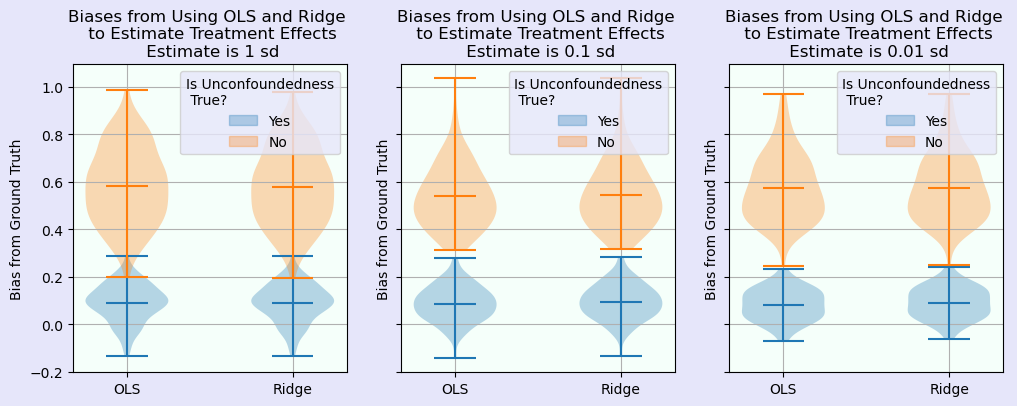

In [171]:
## Plot in violin plots
## add labels for violin plot following: https://stackoverflow.com/questions/33864578/matplotlib-making-labels-for-violin-plots
import matplotlib.patches as mpatches
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))


fig, ax = plt.subplots(nrows=1, ncols=len(sd_list), figsize=(12, 4), sharey=True)
bias_type = '_bias'
for xi in enumerate(sd_list):
    labels = []
    
    add_label( ax[xi[0]].violinplot(df_results.loc[df_results['gt_sd']==xi[1]][[e+bias_type for e in ['ols1','ridge1']]]
                         , showmeans=True), "Yes")    

    add_label(ax[xi[0]].violinplot(df_results.loc[df_results['gt_sd']==xi[1]][[e+bias_type for e in ['ols2','ridge2']]]
                         ,showmeans=True), "No")
    

    ax[xi[0]].set_xticks([1,2])
    ax[xi[0]].set_xticklabels(['OLS','Ridge'])
    ax[xi[0]].set_ylabel('Bias from Ground Truth')
    ax[xi[0]].set_title('Biases from Using OLS and Ridge \n to Estimate Treatment Effects\n Estimate is {0} sd'.format(xi[1]))
    ax[xi[0]].grid()
    ax[xi[0]].legend(*zip(*labels), facecolor='lavender', title='Is Unconfoundedness\n True?')
    ax[xi[0]].set_facecolor('mintcream')
fig.set_facecolor('lavender')
plt.show()
